In [150]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyle = ['-', '-', '-', '-', '-']
fig_width, fig_height = 8, 6

fig_names = [
    "Fig. 1: Result of Pre-Experiment",
]

file_path = "experimental_data.xlsx"

In [91]:
import matplotlib.font_manager as font_manager

# List all fonts available in the Matplotlib font manager
font_list = font_manager.findSystemFonts()
names = []

for font in font_list:
    try:
        prop = font_manager.FontProperties(fname=font)
        name = prop.get_name()
        if name not in names:  # This helps in avoiding duplicates
            names.append(name)
    except Exception as e:
        print(f"Failed to load font: {font}, due to error: {e}")

# Print the sorted list of font names
names.sort()
print("Available fonts for matplotlib:")
for name in names:
    print(name)


Failed to load font: /System/Library/Fonts/Apple Color Emoji.ttc, due to error: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
Failed to load font: /Users/timothyweng/Library/Fonts/SourceHanSansTC-VF.otf, due to error: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
Failed to load font: /Users/timothyweng/Library/Fonts/SourceHanSerifTC-VF.otf, due to error: In FT2Font: Can not load face (SFNT font table missing; error code 0x8e)
Failed to load font: /System/Library/Fonts/Supplemental/NISC18030.ttf, due to error: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
Available fonts for matplotlib:
.Aqua Kana
.Keyboard
.LastResort
.New York
.SF Arabic
.SF Arabic Rounded
.SF Armenian
.SF Armenian Rounded
.SF Camera
.SF Compact
.SF Compact Rounded
.SF Georgian
.SF Georgian Rounded
.SF Hebrew
.SF Hebrew Rounded
.SF NS Mono
.SF NS Rounded
.SF Soft Numeric
.ThonburiUI
Academy Engraved LET
Al Bayan
Al Nile
Al Tarikh


In [92]:
import matplotlib.pyplot as plt

print(plt.rcParams["font.sans-serif"][0])
print(plt.rcParams["font.monospace"][0])

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["DM Sans"]

DM Sans
DejaVu Sans Mono


In [93]:
from typing import List, Tuple, Optional
import pandas as pd
import numpy as np

def calculate_color_with_alpha(color: str, alpha: float) -> str:
    """Modify a hex color string based on an alpha blending towards white."""
    r, g, b = (int(color[i:i+2], 16) for i in (1, 3, 5))
    new_color = (int(alpha * c + (1 - alpha) * 255) for c in (r, g, b))
    return '#{:02x}{:02x}{:02x}'.format(*new_color)

def read_excel_data(file_path: str, sheet_name: Optional[str] = None) -> List[List[str]]:
    """Read an Excel file into a list of lists, transposed, optionally specifying a sheet name."""
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    transposed_data = df.transpose().values.tolist()
    return transposed_data

def preprocess_data(data: List[List[str]], label_row_index: int = 0, multiply: float = 1) -> Tuple[List[List[float]], List[str]]:
    """Convert transposed data rows into separate lists of measurements and labels.
    Assumes the first row (after transposition) is an identifier and thus skips it for measurements."""
    labels = [row[label_row_index] for row in data]  # Extracting labels
    measurements = [[float(value) * multiply for value in row[label_row_index+1:]] for row in data]  # Extracting data
    return measurements[1:], labels[1:]  # Skipping the first set assuming it's an identifier

def calculate_stats(measurements: List[List[float]]) -> Tuple[List[float], List[float]]:
    """Calculate mean and standard deviation of lists of measurements."""
    means = [np.mean(measurement_list) for measurement_list in measurements]
    std_devs = [np.std(measurement_list) for measurement_list in measurements]
    return means, std_devs

In [236]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.stats import t, ttest_ind_from_stats

# Helper function to perform t-test using summary statistics
def ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2):
  se1 = std1 / np.sqrt(nobs1)
  se2 = std2 / np.sqrt(nobs2)
  sed = np.sqrt(se1**2 + se2**2)
  t_stat = (mean1 - mean2) / sed
  df = min(nobs1 - 1, nobs2 - 1)
  p_value = 2 * (1 - t.cdf(np.abs(t_stat), df))
  return t_stat, p_value
  
def finalize_plot(fig_num):
  # plt.title(fig_names[fig_num - 1], pad=13, fontsize='x-large')
  plt.tight_layout(pad=2)
  # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.savefig(f"fig{fig_num}.png")
  
def draw_pre_exp(sheet_name, fig_num):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  print(labels, TBTs, EYs)

  # Create the line graph
  fig1, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
  
  gradient_colors = [colors[0], calculate_color_with_alpha(colors[1], 0.5), colors[1]]

  for i in range(len(labels)):
      ax.scatter(TBTs[i], EYs[i], marker='o', s=25, alpha=1, label=labels[i], color=gradient_colors[i], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(150, 300)
  ax.set_xticks([180, 210, 240, 270])
  ax.set_ylim(20, 22)
  ax.set_yticks([20.5, 21, 21.5])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=5, label=label) for color, label in zip(gradient_colors, labels)]
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=3, handletextpad=0.5, handlelength=0.5, columnspacing=1)

  finalize_plot(fig_num)
  
def draw_main_exp(sheet_name, fig_num):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  tmp_labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  
  labels = []
  for i in range(len(tmp_labels)):
    if not pd.isna(tmp_labels[i]):
      labels.append(tmp_labels[i])
      
  print(labels, TBTs, EYs)

  # Create the line graph
  fig1, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

  gradient_colors = []
  for color in colors[:2]:
    gradient_colors.append(calculate_color_with_alpha(color, 1/3))
    gradient_colors.append(calculate_color_with_alpha(color, 2/3))
    gradient_colors.append(calculate_color_with_alpha(color, 1))
  
  for i in range(len(TBTs)):
      ax.scatter(TBTs[i], EYs[i], marker='o', s=25, alpha=1, label=labels[i//2], color=gradient_colors[i//2], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(180, 420)
  ax.set_xticks([240, 300, 360])
  ax.set_ylim(20.5, 23.5)
  ax.set_yticks([21, 22, 23])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=5, label=label) for color, label in zip(gradient_colors, labels)]
  order = [0, 3, 1, 4, 2, 5]
  dots = [dots[i] for i in order]
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=3, handletextpad=0.5, handlelength=0.5, columnspacing=1)
  
  finalize_plot(fig_num)
  
def draw_main_exp_line(sheet_name, fig_num):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  tmp_labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  
  labels = ['WWDT', 'CTL']
  print(labels, TBTs, EYs)
  
  # Create the line graph
  fig1, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
  
  gradient_colors = []
  for color in colors[:2]:
    gradient_colors.append(calculate_color_with_alpha(color, 1/3))
    gradient_colors.append(calculate_color_with_alpha(color, 2/3))
    gradient_colors.append(calculate_color_with_alpha(color, 1))

  for i in range(len(TBTs)):
    ax.scatter(TBTs[i], EYs[i], marker='o', s=25, alpha=1, label=labels[i//6], color=colors[i//6], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(180, 420)
  ax.set_xticks([240, 300, 360])
  ax.set_ylim(20.5, 23.5)
  ax.set_yticks([21, 22, 23])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=5, label=label) for color, label in zip(colors, labels)]
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=2, handletextpad=0.5, handlelength=0.5, columnspacing=1)
    
  # Define the modified exponential model
  def exponential_model(t, k, EY_max):
    return EY_max * (1 - np.exp(-k * t))

  # Prepare data for WWDT and CTL
  wwdt_data = {'TBT': np.array(TBTs[:6]), 'EY': np.array(EYs[:6])}
  ctl_data = {'TBT': np.array(TBTs[6:]), 'EY': np.array(EYs[6:])}
  all_data = {'TBT': np.array(TBTs), 'EY': np.array(EYs)}

  # Fit the exponential model to WWDT data
  params_wwdt_exp, pcov_wwdt_exp = curve_fit(exponential_model, wwdt_data['TBT'], wwdt_data['EY'], p0=[0.005, 25], bounds=(0, [np.inf, np.inf]))

  # Fit the exponential model to CTL data
  params_ctl_exp, pcov_ctl_exp = curve_fit(exponential_model, ctl_data['TBT'], ctl_data['EY'], p0=[0.005, 25], bounds=(0, [np.inf, np.inf]))
  
  params_all_exp, pcov_all_exp = curve_fit(exponential_model, all_data['TBT'], all_data['EY'], p0=[0.005, 25], bounds=(0, [np.inf, np.inf]))

  # Plot the fitted exponential curves
  for tech, params, color in zip(['WWDT Exp', 'CTL Exp'], [params_wwdt_exp, params_ctl_exp], colors[:2]):
      TBT_range = np.linspace(100, 500, 100)
      EY_pred = exponential_model(TBT_range, *params)
      ax.plot(TBT_range, EY_pred, color=color, linestyle='-', label=f'{tech} Fit: k={params[0]:.3f}, EY_max={params[1]:.1f}')

  # Compare the parameters for exponential model
  k_wwdt, EY_max_wwdt = params_wwdt_exp
  k_ctl, EY_max_ctl = params_ctl_exp
  k_all, EY_max_all = params_all_exp

  print(f'Parameter k for WWDT (Exp): {k_wwdt}')
  print(f'Parameter EY_max for WWDT (Exp): {EY_max_wwdt}')
  print(f'Parameter k for CTL (Exp): {k_ctl}')
  print(f'Parameter EY_max for CTL (Exp): {EY_max_ctl}')
  print(f'Parameter k for ALL (Exp): {k_all}')
  print(f'Parameter EY_max for ALL (Exp): {EY_max_all}')
  
  # Calculate standard errors of the fitted parameters
  perr_wwdt_exp = np.sqrt(np.diag(pcov_wwdt_exp))
  perr_ctl_exp = np.sqrt(np.diag(pcov_ctl_exp))

  # Perform t-tests for the parameters
  t_stat_k, p_value_k = ttest_ind_from_stats(mean1=k_wwdt, std1=perr_wwdt_exp[0], nobs1=len(wwdt_data['TBT']),
                                              mean2=k_ctl, std2=perr_ctl_exp[0], nobs2=len(ctl_data['TBT']))

  t_stat_EY_max, p_value_EY_max = ttest_ind_from_stats(mean1=EY_max_wwdt, std1=perr_wwdt_exp[1], nobs1=len(wwdt_data['TBT']),
                                                        mean2=EY_max_ctl, std2=perr_ctl_exp[1], nobs2=len(ctl_data['TBT']))

  print(f'T-test result for k: t-statistic = {t_stat_k:.3f}, p-value = {p_value_k}')
  print(f'T-test result for EY_max: t-statistic = {t_stat_EY_max:.3f}, p-value = {p_value_EY_max}')
    
  finalize_plot(fig_num)

[[nan, 'WWDT', 'CTL-fast', 'CTL-slow'], ['TBT', 263, 187, 269], ['EY', 0.213, 0.2065, 0.2152]]
['WWDT', 'CTL-fast', 'CTL-slow'] [263, 187, 269] [21.3, 20.65, 21.52]


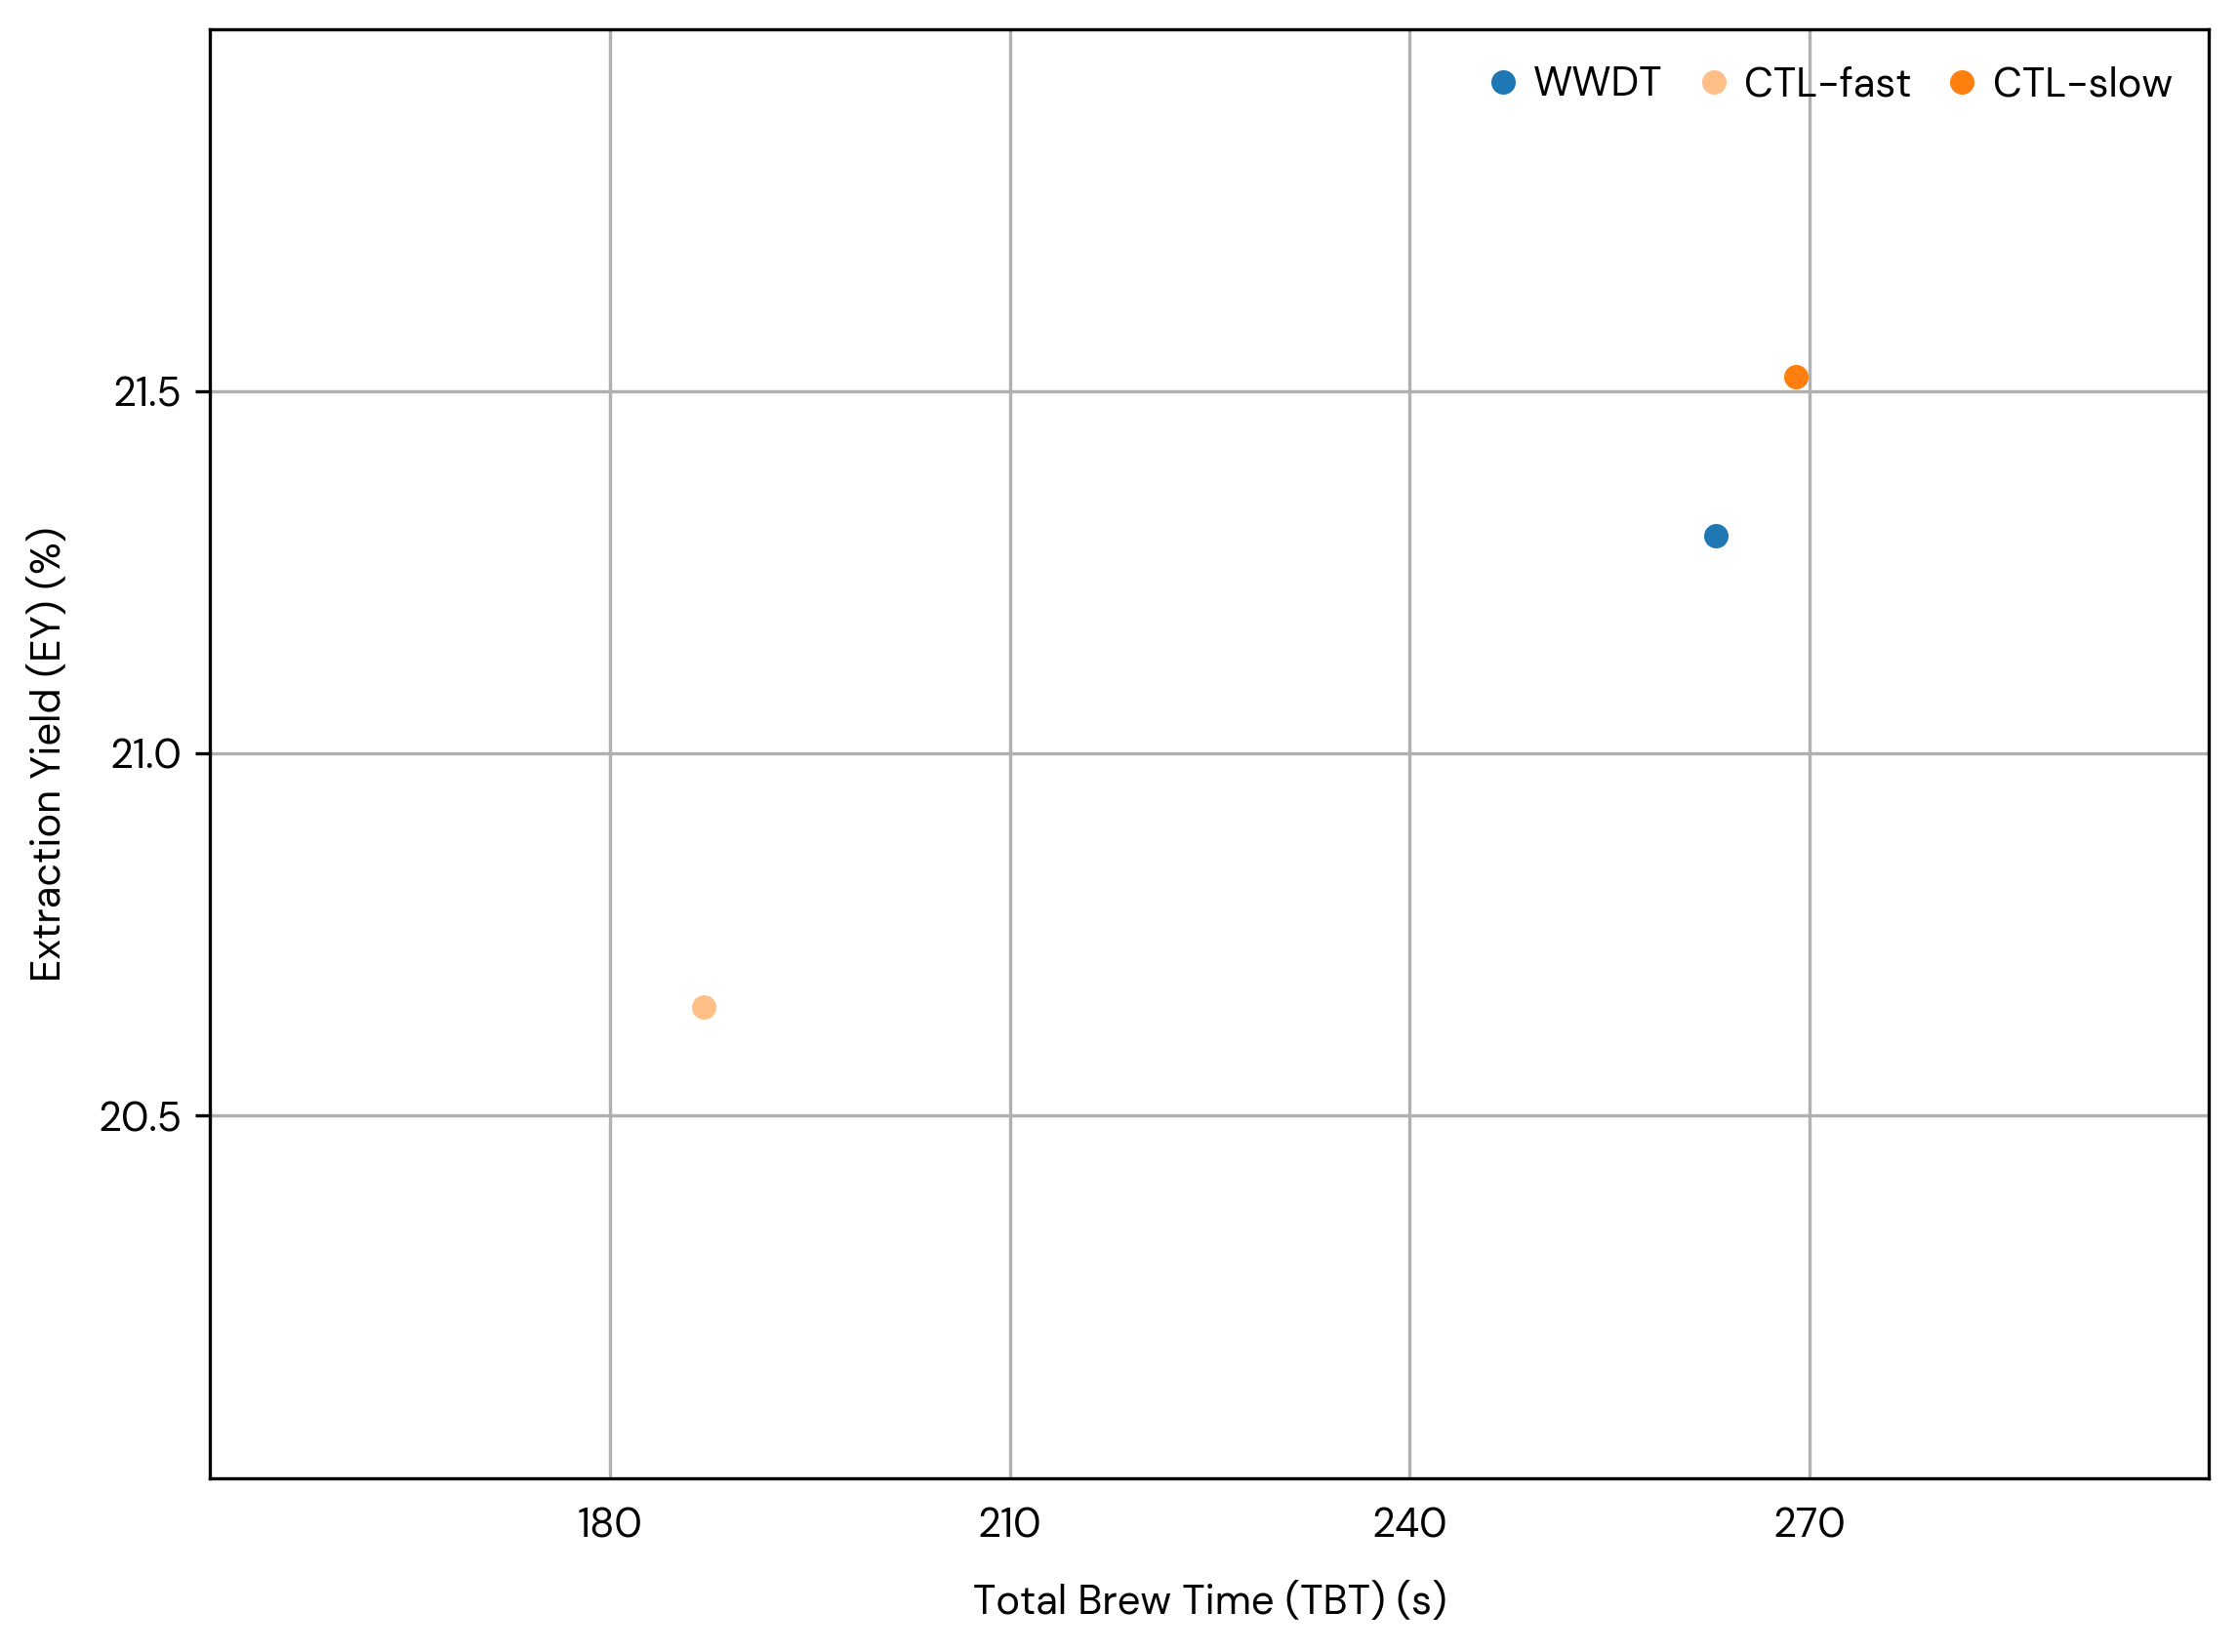

In [237]:
draw_pre_exp('Pre', 1)
# draw_main_exp('Main', 2)
# draw_main_exp_line('Main', 3)